In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from KCrossVal import kFoldCross, MeanAbsError, BinaryAccuracy
import time

In [5]:
dataset_df = pd.read_csv('./data/Financial_Data.csv')
dataset_df = dataset_df.sample(frac=1)
excluded_cols = ['Stock', 'Sector', 'Class', 'Year', 'PRICE VAR [%]']
num_cols = [c for c in dataset_df.columns if c not in excluded_cols]
X_dev = dataset_df[num_cols].to_numpy()
Y_float = dataset_df['PRICE VAR [%]'].to_numpy()
Y_bin = dataset_df['Class'].to_numpy()

print('N of rows =',len(X_dev))

print('N of rows where PRICE VAR [%] > 100 =',np.sum((Y_float>100).astype(int)))

# cap PRICE VAR [%] to 100
Y_float[Y_float>100] = 100
#not_outliers = np.abs(Y_float - Y_float.mean()) < Y_float.std()*0.01

#X_dev = X_dev[not_outliers]
#Y_float = Y_float[not_outliers]
#Y_bin = Y_bin[not_outliers]



N of rows = 19500
N of rows where PRICE VAR [%] > 100 = 735


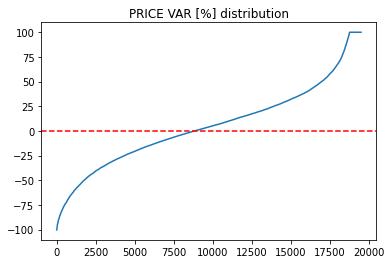

In [36]:
plt.plot(np.sort(Y_float))
plt.title('PRICE VAR [%] distribution')
plt.axhline(0, color='red',linestyle='--')

In [6]:
np.atleast_2d(Y_float).transpose()

array([[ 20.3125    ],
       [ 14.9351149 ],
       [ 48.80952494],
       ...,
       [ 51.48968444],
       [-32.49670406],
       [-33.17222532]])

In [7]:
C_values = [1]
results = []
for C in C_values:
    reg = linear_model.LogisticRegression(C=C,max_iter=1000)
    res = kFoldCross(reg.fit, reg.predict, X_dev, Y_bin, 5, MeanAbsError)
    res = C, res[0], res[1], res[3]
    results.append(res)

df = pd.DataFrame(results, columns=['C', 'ValErr_mean', 'ValErr_std', 'seconds'])
df.sort_values(by='ValErr_mean')

,C,ValErr_mean,ValErr_std,seconds
0,1,0.425949,0.006208,47.304725


In [16]:
alpha = [1e3,1e4,1e5]
results = []
for a in alpha:
    reg = linear_model.Ridge(alpha=a)
    res = kFoldCross(reg.fit, reg.predict, X_dev, Y_float, 5, MeanAbsError)
    res = a, res[0], res[1], res[3]
    results.append(res)

df = pd.DataFrame(results, columns=['alpha', 'ValErr_mean', 'ValErr_std', 'seconds'])
df.sort_values(by='ValErr_mean')

,alpha,ValErr_mean,ValErr_std,seconds
1,10000.0,31.903411,0.161540,1.828334
0,1000.0,31.994287,0.113398,2.140377
2,100000.0,32.004979,0.155721,1.773333


In [24]:
corr_values = []
for c in num_cols:
    array = dataset_df[c]
    corr = np.corrcoef(array, Y_float)[0,1]
    corr_values.append((corr, c))

corr_values.sort(key= lambda tup: -np.abs(tup[0]))
print('top correlated columns to Y_float')
corr_values[:3]

top correlated columns to Y_float


[(0.0787488753412246, 'shortTermCoverageRatios'),
 (0.07825967239043417, 'payoutRatio'),
 (0.06500862906163313, 'Interest Debt per Share')]